<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/GST/notebooks/Intuition_of_Geometric_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Sample

In [5]:
!wget -q https://www.dropbox.com/s/z2jijn8qp7xst8l/IMG_0203.jpg -O cat1.jpg
!wget -q https://www.dropbox.com/s/869hzklub0ahtra/IMG_0204.jpg -O cat2.jpg

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [7]:
def imshow(img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
cat1 = cv2.cvtColor(cv2.imread("cat1.jpg"), cv2.COLOR_BGR2RGB)
cat2 = cv2.cvtColor(cv2.imread("cat2.jpg"), cv2.COLOR_BGR2RGB)

print(f"cat1 shape: {cat1.shape}")
print(f"cat2 shape: {cat2.shape}")

cat1 shape: (3264, 2448, 3)
cat2 shape: (3264, 2448, 3)


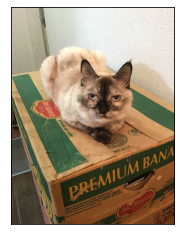

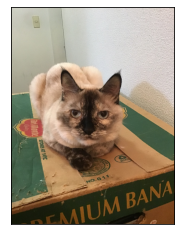

In [9]:
imshow(cat1)
imshow(cat2)

## Affine Transform

$$\left(\begin{array}{l}
x^{\prime} \\
y^{\prime} \\
1
\end{array}\right)=\left(\begin{array}{lll}
a & b & t_{x} \\
c & d & t_{y} \\
0 & 0 & 1
\end{array}\right)\left(\begin{array}{l}
x \\
y \\
1
\end{array}\right)$$

OpenCV3's API of Affine Transform

```python
cv2.warpAffine(
    src,           # ndarray src image
    M,             # convert Matrix [2x3]
    dsize,         # tuple of image size (W, H)
    [dst],         # background image
    [flags],       # interpolation
                   # (INTER_NEAREST, INTER_LINEAR)
                   # (INTER_CUBIC, INTER_LANCZOS4) 
    [borderMode],  # (BORDER_CONSTANT, BORDER_REPLICATE,
                   #  BORDER_REFLECT, ...)
    [borderValue]  # (BGR)
)
```

In [10]:
# img shape
h, w, c = cat1.shape

# vertical moving matrix
mat = np.array([
    [1, 0, 0],
    [0, 1, 300]
], dtype=np.float32)

In [11]:
cat1_affine = cv2.warpAffine(cat1, mat, (w, h))

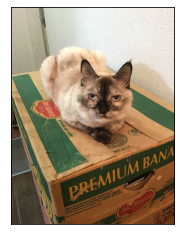

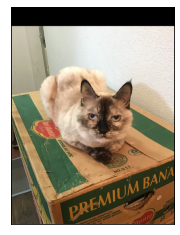

In [12]:
imshow(cat1)
imshow(cat1_affine)

## Affine Transform by Kornia (PyTorch Library)

In [13]:
!pip3 install kornia

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 752.0MB 22kB/s 
ERROR: torchvision 0.6.1+cu101 has requirement torch==1.5.1, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101


In [14]:
import torch
import kornia

In [15]:
# convert to torch tensor
cat1_tensor = kornia.image_to_tensor(cat1, keepdim=False)  # BxCxHxW

print(cat1_tensor.shape)
print(cat1_tensor.dtype)

torch.Size([1, 3, 3264, 2448])
torch.uint8


In [16]:
cat1_tensor.min(), cat1_tensor.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [17]:
# we optimizer this matrix parameters
mat_tensor = torch.tensor([[
    [1, 0, 0],
    [0, 1, 300]
]], dtype=torch.float)

print(mat_tensor.shape)

torch.Size([1, 2, 3])


In [18]:
cat1_tensor_affine = kornia.warp_affine(
    cat1_tensor.float(),
    mat_tensor,cat1_tensor = T.ToTensor()(cat1)
    dsize=(h, w)
)

In [19]:
cat1_tensor_affine.min(), cat1_tensor_affine.max()

(tensor(0.), tensor(255.0000))

In [64]:
def imshow_tensor(img_tensor):
    r"""
    img_tensor (torch.Tensor): the image tensor of shape [C x H x W]
    """

    if img_tensor.max() <= 1.:
        img_tensor = img_tensor * 255
    img = img_tensor.permute(1, 2, 0).to(dtype=torch.uint8).cpu().numpy()
    imshow(img)

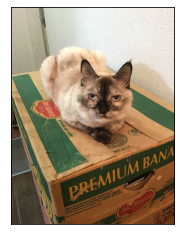

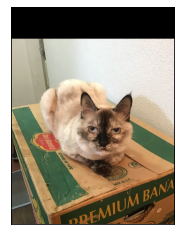

In [65]:
imshow_tensor(cat1_tensor[0])
imshow_tensor(cat1_tensor_affine[0])

## Affine Transform by Pure PyTorch

### [torch.nn.functional.affine_grid(theta, size, align_corners=None)](https://pytorch.org/docs/stable/nn.functional.html#affine-grid)

#### Purpose

Generates a 2D or 3D flow field (sampling grid), given a batch of affine matrices theta

#### Parameters
- `theta (Tensor)`: input batch of affine matrices with shape (N x 2 x 3) for 2D or (N x 3 x 4) for 3D
- `size (torch.Size)`: the target output image size. (N x C x H x W) for 2D or (N x C x D x H x W)
- `align_corners (bool)`: if True, consider -1 and 1 to refer to the centers of the corner pixels rather than the image corners. Refer to grid_sample() for a more complete description. A grid generated by affine_grid() should be passed to grid_sample() with the same setting for this option. Default: False

#### Returns

output Tensor of size (N x H x W x 2)



In [22]:
import torch.nn.functional as F
from torchvision import transforms as T

In [32]:
cat1_tensor = T.ToTensor()(cat1).unsqueeze(0)
cat2_tensor = T.ToTensor()(cat2).unsqueeze(0)

print(cat1_tensor.shape)
print(cat1_tensor.dtype)
print(cat1_tensor.min(), cat1_tensor.max())

torch.Size([1, 3, 3264, 2448])
torch.float32
tensor(0.) tensor(1.)


In [52]:
affine_metrices = torch.tensor([[
    [1, 0, 0],
    [0, 1, -0.3]
]], dtype=torch.float, requires_grad=True)

print(affine_metrices.shape)
print(affine_metrices.dtype)

torch.Size([1, 2, 3])
torch.float32


In [53]:
affine_grid = F.affine_grid(affine_metrices, cat1_tensor.shape)

print(affine_grid.shape)
print(affine_grid.dtype)

torch.Size([1, 3264, 2448, 2])
torch.float32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [54]:
# grid position before affine translation
affine_grid[..., 0]

tensor([[[-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         ...,
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996]]],
       grad_fn=<SelectBackward>)

In [55]:
# grid position after affine translation
affine_grid[..., 1]

tensor([[[-1.2997, -1.2997, -1.2997,  ..., -1.2997, -1.2997, -1.2997],
         [-1.2991, -1.2991, -1.2991,  ..., -1.2991, -1.2991, -1.2991],
         [-1.2985, -1.2985, -1.2985,  ..., -1.2985, -1.2985, -1.2985],
         ...,
         [ 0.6985,  0.6985,  0.6985,  ...,  0.6985,  0.6985,  0.6985],
         [ 0.6991,  0.6991,  0.6991,  ...,  0.6991,  0.6991,  0.6991],
         [ 0.6997,  0.6997,  0.6997,  ...,  0.6997,  0.6997,  0.6997]]],
       grad_fn=<SelectBackward>)

### [torch.nn.functional.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=None)](https://pytorch.org/docs/stable/nn.functional.html#grid-sample)

#### Purpose

入力テンソルと変換前後のグリッドの位置情報から、出力テンソルを計算する。

変換前後で位置が一致していない値に関しては、補間計算を行っている。その際に補間を行う手法を選択することが可能である。

入力するグリッドは、入力テンソルの空間次元に合わせて−1から1までの値で正規化されている。もしもグリッドの値が-1から1までの範囲外にあるときは、`padding_mode`によって計算される。

#### Parameters

- `input (Tensor)`: input of shape (N, C, H_in, W_in) (4-D case) or (N, C, D_in, H_in, W_in) (5-D case)
- `grid (Tensor)`: flow-field of shape (N, H_out, W_out, 2) (4-D case) or (N, D_out, H_out, W_out, 3) (5-D case)
- `mode (str)`: interpolation mode to calculate output values `bilinear` | `nearest`. Default: `bilinear`
- `padding_mode (str)`: padding mode for outside grid values `zeros` | `border` | `reflection`. Default: `zeros`
- `align_corners (bool, optional)`: Geometrically, we consider the pixels of the input as squares rather than points. If set to True, the extrema (-1 and 1) are considered as referring to the center points of the input’s corner pixels. If set to False, they are instead considered as referring to the corner points of the input’s corner pixels, making the sampling more resolution agnostic. This option parallels the align_corners option in interpolate(), and so whichever option is used here should also be used there to resize the input image before grid sampling. Default: False

#### Returns

output Tensor

In [56]:
cat1_tensor_affine = F.grid_sample(cat1_tensor, 
                                   affine_grid,
                                   mode="bilinear")
cat1_tensor
print(cat1_tensor_affine.shape)
print(cat1_tensor_affine.dtype)
print(cat1_tensor_affine.min(), cat1_tensor_affine.max())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([1, 3, 3264, 2448])
torch.float32
tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


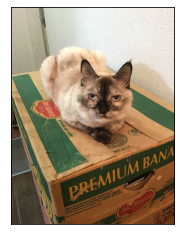

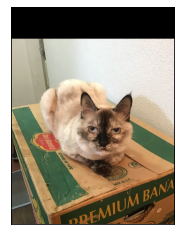

In [57]:
imshow_tensor(cat1_tensor[0]*255)
imshow_tensor(cat1_tensor_affine[0]*255)

## Spatial Transformer Network

Gemetric Style Transferでは、アフィン変換などのパラメータをCNNを通して学習させている。

そこで同じくパラメータを推定して画像分類に適用したSpatial Transformer Networkの構造を考える。

- `localization network`では、アフィン変換などのパラメータを推定するネットワークを通常のCNNに組み込んだモデルである。本モデルでは、教師なしでこうしたパラメータを学習させていく。
- `grid generator`では、入力テンソルとアフィン変換のパラメータから、変換前後のピクセル位置を示すグリッドテンソルを取得する。
- `sampler`では、得られたグリッドテンソルを元に入力テンソルの各空間の位置を変換する。

![](https://brsoff.github.io/tutorials/_images/stn-arch.png)

[[arXiv:1506.02025] Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

[[PyTorch Official Implementation] DEPICTING SPATIAL TRANSFORMER NETWORKS](https://brsoff.github.io/tutorials/intermediate/spatial_transformer_tutorial.html#depicting-spatial-transformer-networks)

In [79]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [105]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(30, 40, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(40 * 14 * 14, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 40 * 14 * 14)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        return x

In [106]:
model = Net()

In [107]:
apply_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [108]:
cat1_tensor = apply_transforms(Image.fromarray(cat1)).unsqueeze(0)
cat2_tensor = apply_transforms(Image.fromarray(cat2)).unsqueeze(0)

print(cat1_tensor.shape)
print(cat1_tensor.dtype)
print(cat1_tensor.min(), cat1_tensor.max())

torch.Size([1, 3, 224, 224])
torch.float32
tensor(0.0039) tensor(1.)


In [110]:
cat1_tensor_output = model(cat1_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


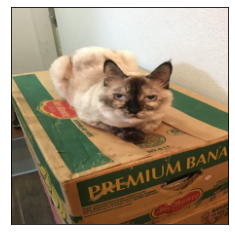

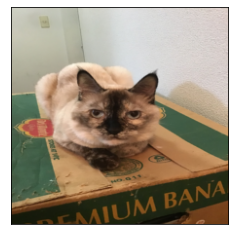

In [116]:
imshow_tensor(cat1_tensor_output[0])
imshow_tensor(cat2_tensor[0])

In [124]:
inputs = cat1_tensor.clone()
target = cat2_tensor.clone()
optimizer = optim.SGD(model.parameters(), lr=0.001)

for i in range(100):
    optimizer.zero_grad()

    output = model(inputs)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(i, loss.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0 0.01792922057211399
10 0.017929207533597946
20 0.0179292019456625
30 0.01792920008301735
40 0.017929205670952797
50 0.017929207533597946
60 0.01792920008301735
70 0.0179292019456625
80 0.01792920008301735
90 0.01792920008301735


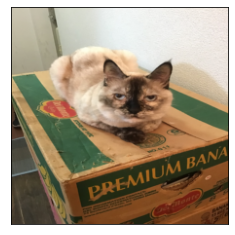

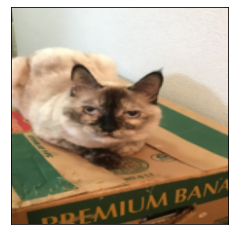

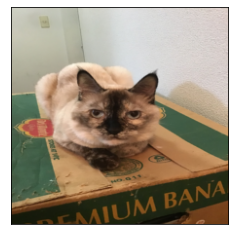

In [125]:
imshow_tensor(inputs[0])
imshow_tensor(output[0])
imshow_tensor(target[0])

## How to Apply Affine Transform by PyTorch

PyTorchではアフィン変換を`F.affine_grid`と`F.grid_sample`を使用しているが、これらの関数はそれぞれ`Tensor`クラスの関数である`affine_grid_generator`と`grid_sampler`を呼び出しており、これらの関数自体の実装はC++で行われている。

- [[C++] affine_grid_generator](https://github.com/pytorch/pytorch/blob/74b65c32be68b15dc7c9e8bb62459efbfbde33d8/aten/src/ATen/native/AffineGridGenerator.cpp#L77)
- [[C++] grid_sampler](https://github.com/pytorch/pytorch/blob/877c96cddfebee00385307f9e1b1f3b4ec72bfdc/aten/src/ATen/native/GridSampler.cpp#L429)

[Official API Docs](https://pytorch.org/cppdocs/api/library_root.html)

### [C++] affine_grid_generator

ざっくりとC++のソースコードを追っていく。なおTensorの形状チェックを行って呼び出す関数を決めている処理は不必要であるため、省いて考えていく。

なお以下では2次元画像に対しての処理を考えていく。

アフィン変換を行う流れとしては、まずは`affine_grid_generator`を使用して[-1, 1]に正規化した同次座標形式の座標情報を作成し、`reshape`を利用してアフィン変換のパラメータ $\theta$ を適用する。

```cpp
// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor affine_grid_generator(const Tensor& theta, IntArrayRef size, bool align_corners) {
  // :param Tensor: [N, C, H, W] for 2D, [N, C, D, H, W] for 3D
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // Tensorが4次元か5次元であることをチェック
  // 4次元の場合
  // → [x] affine_grid_generator_4D
  // 5次元の場合
  // → [ ] affine_grid_generator_5D
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor affine_grid_generator_4D(
    const Tensor& theta,
    int64_t N,
    int64_t C,
    int64_t H,
    int64_t W,
    bool align_corners) {
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // base_grid: [N, H, W, 3]
  Tensor base_grid = make_base_grid_4D(theta, N, C, H, W, align_corners);
  // apply Affine Matrices
  // base_grid x theta: [N, HxW, 3] x [N, 3, 2]
  // base_gridのあるサンプルのある座標のデータの形状は[1, 1, 3]であり、幅(x)・高さ(y)・1のデータで構成される。
  // bmmでは1つの計算を見てみるとアフィン変換に対応
  // [[x, y, 1]] x [[a, c], [b, d], [tx, ty]]
  auto grid = base_grid.view({N, H * W, 3}).bmm(theta.transpose(1, 2));
  // base_grid: [N, H, W, 2]
  return grid.view({N, H, W, 2});
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor make_base_grid_4D(
    const Tensor& theta,
    int64_t N,
    int64_t C,
    int64_t H,
    int64_t W,
    bool align_corners) {
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // thetaと同じ型やデバイス設定で、入力テンソルに合わせてTensorを初期化する
  // base_grid: [N, H, W, 3]
  auto base_grid = at::empty({N, H, W, 3}, theta.options());

  // select(dim=-1, index=0)は[N,H,W,3]のうち最後の次元でTensorを分割して、3つに分解したうちの0番目のTensorを抽出できる。
  // x方向のグリッド(shape: [W])を[-1, 1]で計算
  // ブロードキャストでは[N, H, W]の中の[W]にグリッドをコピーして、高さ方向にブロードキャスト
  base_grid.select(-1, 0).copy_(linspace_from_neg_one(theta, W, align_corners));
  // y方向のグリッド(shape: [H, 1])を[-1, 1]で計算
  // ブロードキャストでは[N, H, W]の中の[H]にグリッドをコピーして、幅方向にブロードキャスト
  base_grid.select(-1, 1).copy_(linspace_from_neg_one(theta, H, align_corners).unsqueeze_(-1));
  // すべて1で埋める (同次座標に対応)
  base_grid.select(-1, 2).fill_(1);

  return base_grid;
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
at::Tensor linspace_from_neg_one(const Tensor& grid, int64_t num_steps, 
                                 bool align_corners) {

  // :param num_steps: グリッド計算する範囲であり、画像の幅や高さを指定する
  if (num_steps <= 1) {
    return at::tensor(0, grid.options());
  }
  // グリッドを指定の幅や高さに関して、[-1, 1]の範囲で正規化を行っている。
  auto range = at::linspace(-1, 1, num_steps, grid.options());
  if (!align_corners) {
    range = range * (num_steps - 1) / num_steps;
  }
  return range;
}
```

### [C++] grid_sampler

こちらでもC++の実装をざっくり追っていく。同様にTensorの形状チェックなどの処理は省いていく。

```cpp
// /aten/src/ATen/native/GridSampler.cpp
Tensor grid_sampler(const Tensor& input, const Tensor& grid,
                    int64_t interpolation_mode, int64_t padding_mode,
                    bool align_corners) {
  // :param input: [N, C, H, W] for 2D, [H, C, D, H, W] for 3D
  // :param grid: [N, H, W, 2] for 2D, [N, D, H, W, 3] for 3D
  // :param interpolation_mode: `bilinear` || `nearest`
  // :param padding_mode: `zeros` || `border` || `reflection`
  // :param align_corners: 
  
  // 入力Tensorとグリッドが型定義されているか検証する
  // 型定義がある場合には、Tensorの設定をコピーしておく
  auto input_opt = input.options();
  auto grid_opt = grid.options();
  // 入力Tensorとグリッドのデバイス設定が一致するか検証する
  // 入力Tensorとグリッドの型が一致するか検証する
  // 入力Tensorとグリッドのlayout(/c10/core/Layout.h)が一致するか検証する
  // 入力Tensorの形状が4次元か5次元であり、グリッドの形状が一致するか検証する
  // 入力Tensorとグリッドのバッチサイズが一致するか検証する
  // グリッドの最後の次元数が、入力Tensorが2次元であるか3次元であるか一致するか検証する
  // 入力Tensorの各次元の要素数が正値であることを検証する

  // cudnn does not support inputs larger than 1024
  if (at::native::cudnn_is_acceptable(input) &&
      at::native::cudnn_is_acceptable(grid) &&
      static_cast<GridSamplerInterpolation>(interpolation_mode) == GridSamplerInterpolation::Bilinear &&
      static_cast<GridSamplerPadding>(padding_mode) == GridSamplerPadding::Zeros &&
      align_corners &&
      input.dim() == 4 &&
      input.size(1) <= 1024) {
    return cudnn_grid_sampler(input, grid);
  }
  if (input.dim() == 4) {
    return at::grid_sampler_2d(input, grid, interpolation_mode, padding_mode, align_corners);
  } else {
    return at::grid_sampler_3d(input, grid, interpolation_mode, padding_mode, align_corners);
  }
}

// /aten/src/ATen/native/GridSampler.cpp
Tensor grid_sampler_2d_cpu(const Tensor& input, const Tensor& grid,
                           int64_t interpolation_mode, int64_t padding_mode,
                           bool align_corners) {
  // :param input: [N, C, H, W]
  // :param grid: [N, H, W, 2]

  return grid_sampler_2d_cpu_kernel(
    kCPU, input, grid, interpolation_mode, padding_mode, align_corners);
}

// /aten/src/ATen/native/cpu/GridSamplerKernel.cpp

```

## Thin-Plate Spline